In [1]:
#pip install natsort
import pandas as pd
import numpy as np
import natsort # 파일 숫자 정렬용 라이브러리
import os
import librosa
import re

In [2]:
frame_count = 30 # 1초 = 30 frame
skeleton_count = 42 # 42개 ( 21 * 2 ( 왼손 & 오른손 ))
coord_count = 3 # X, Y, Z

n_mfcc = 20

In [3]:
dir_extracted_features = np.empty((0,n_mfcc), float)
dir_extracted_skeletons = np.empty((0,frame_count, coord_count, skeleton_count), float)
dir_extracted_sec = []
dir_extracted_coord = []

## 0. MFCC 코드

In [4]:
#https://www.analyticsvidhya.com/blog/2022/03/implementing-audio-classification-project-using-deep-learning/
#https://stackoverflow.com/questions/52841335/how-can-i-pad-wav-file-to-specific-length
from librosa.util import fix_length
from librosa import load
from tqdm import tqdm

def features_extractor(file):
    #load the file (audio)
    file_name = file
    sf = 44100 # sampling frequency of wav file
    
    audio, sample_rate = librosa.load(file_name, sr=sf, mono=True) # mono=True converts stereo audio to mono
        
    #we extract mfcc'
    mfccs_features = librosa.feature.mfcc(y=audio, n_mfcc=20, sr=sf) ## --> n_mfcc : 20 ~ 50
    #print("mfccs_features",mfccs_features.shape)

    mfccs_scaled_features = np.mean(mfccs_features.T,axis=0) ## 평균으로 출력
    
    #print("mfccs_scaled_features", mfccs_scaled_features.shape)
    return mfccs_scaled_features

## 1. feature 데이터 가공하기

In [5]:
def features_extractor_dir(directory):
    file_list = natsort.natsorted(os.listdir(directory))

    extracted_sec = []

    extracted_features=[]
    extracted_len_features=[]
    file_total_len = 1 # feature_input 길이 ex). 1초, 2초

    count = 0

    for filename in file_list:
        filename_split = re.split(r'-|\.wav', filename)
        sec = int(filename_split[1])
        extracted_sec.append(sec)
    
        file_name = os.path.join(directory, filename) ## 만약에 2초마다 붙이고 싶으면
        # printf(filename)
        data = features_extractor(file_name)
        extracted_len_features = np.concatenate((extracted_len_features, data))
        count+=1
    
        if (count == file_total_len):
            extracted_features.append(extracted_len_features)
        
            extracted_len_features=[]
            count = 0

    extracted_features = np.array(extracted_features)
    return extracted_features, extracted_sec

### 1.1 features_audio_dir

In [6]:
#audio_dir_list = ["music1_audio_ground_truth_wav", "music2_audio_ground_truth_wav","music3_audio_ground_truth_wav"]
audio_dir_list = ["music3_audio_ground_truth_wav"]

for dir_name in audio_dir_list:
        extracted_features, extracted_sec = features_extractor_dir(dir_name)
        
        dir_extracted_features = np.append(dir_extracted_features,extracted_features, axis=0)
        dir_extracted_sec.append(extracted_sec) # extracted_sec

## 2. skeleton 데이터 가공하기

In [7]:
def skeleton_extractor_dir(directory, extracted_sec_len):
    skeleton = pd.read_csv(directory)

    extracted_skeleton=[] ### 궁금한게 초 길이 ## 다음 순차적으로 데이터 이어 붙이기 해야할 것같음
    extracted_coord = []
    
    start_sec = 0 # 시작 sec
    end_sec = extracted_sec_len

    interval = 0
    start_frame = (start_sec+interval) * 30 # 실제 csv : ( row = 2부터 시작 ) // 한 칸씩 떼기
    end_frame = (end_sec+interval) * 30
    
    extracted_4dim_skeleton=np.zeros((frame_count,coord_count,skeleton_count), float)
    
    for frame_num in range(start_frame, end_frame, frame_count): # start_frame ~ end_frame
        extracted_total_skeleton=[]
        extracted_3dim_skeleton = np.zeros((30,3),float)

        start_index = 0
        end_index = skeleton.shape[1]
        for index in range(start_index, end_index, 3):
            extracted_2dim_list = skeleton.iloc[frame_num:(frame_num+frame_count), index:(index+3)]
        
            coord_name = re.split(r'_LX|_LY|_LX|_RX|_RY|_RZ', list(extracted_2dim_list)[0])[0]
            
            extracted_coord.append(coord_name)
            extracted_3dim_skeleton = np.append(extracted_3dim_skeleton,np.array(extracted_2dim_list), axis=0)
            
        extracted_3dim_skeleton = np.delete(extracted_3dim_skeleton,range(0,frame_count), axis=0 )
    
        extracted_3dim_skeleton = extracted_3dim_skeleton.reshape(frame_count,coord_count,skeleton_count)
        extracted_4dim_skeleton = np.append(extracted_4dim_skeleton, extracted_3dim_skeleton, axis=0)
        
    extracted_4dim_skeleton = np.delete(extracted_4dim_skeleton,range(0,frame_count), axis=0 )
    extracted_4dim_skeleton = extracted_4dim_skeleton.reshape(end_sec, frame_count, coord_count,skeleton_count)

    
    return extracted_4dim_skeleton, extracted_coord
    

In [8]:
#video_dir_list = ['music1_hand_result_ground_truth.csv','music2_hand_result_ground_truth.csv','music3_hand_result_ground_truth.csv']
video_dir_list = ['music3_hand_result_ground_truth.csv']
video_index = 0

for dir_name in video_dir_list:
    extracted_sec_len = len(dir_extracted_sec[video_index])
    extracted_dim_skeleton, extracted_coord = skeleton_extractor_dir(dir_name, extracted_sec_len)
    
    dir_extracted_skeletons = np.append(dir_extracted_skeletons, extracted_dim_skeleton, axis=0)
    dir_extracted_coord.append(extracted_coord)
    
    video_index+=1

### skeleton 데이터 차원 축소

In [9]:
### ( 65, 30, 3, 42 ) --> ( 65, 3780 )
extracted_contraction_skeleton = []
total_sec = dir_extracted_skeletons.shape[0]
skeleton_row_count = frame_count*coord_count*skeleton_count


for i in range(total_sec):
    contraction_skeleton = np.ravel(dir_extracted_skeletons[i], order='C')
    extracted_contraction_skeleton = np.append(extracted_contraction_skeleton, contraction_skeleton, axis = 0)
        
extracted_contraction_skeleton = extracted_contraction_skeleton.reshape(total_sec, skeleton_row_count)

## 3. Train, Test 데이터 생성

In [10]:
## input (mfcc audio) : extracted_features ( sec, features ) 
## output (skeleton video) : extracted_contraction_skeleton ( sec, frame_count * coord_count * skeleton_count)
print("input : ", dir_extracted_features.shape)
print("output : ", extracted_contraction_skeleton.shape)


input :  (150, 20)
output :  (150, 3780)


In [11]:
import numpy as np
from sklearn.preprocessing import MinMaxScaler

def train_test_normalize(input_data, output_data):
    # create training and test set 
    
    inputs = input_data
    outputs = output_data
    
    #####################################################################################################
    scaler = MinMaxScaler()
    scaler.fit(inputs)
    inputs = scaler.transform(inputs)
    #####################################################################################################
    
    #####################################################################################################
    scaler = MinMaxScaler()
    scaler.fit(outputs)
    outputs = scaler.transform(outputs)
    #####################################################################################################
    
    ### Train Test Split
    from sklearn.model_selection import train_test_split
    X_train,X_test,y_train,y_test=train_test_split(inputs,outputs,test_size=0.2,random_state=7)
    
    print(X_train.shape)
    print(y_train.shape)
    print(X_test.shape)
    print(y_test.shape)
    
    X_train, y_train = np.array(X_train), np.array(y_train) # 2차원 변경
    X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1 )) # LSTM 모델을 위해 3차원 변경
    
    X_test, y_test = np.array(X_test), np.array(y_test) # 2차원 변경
    X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1 )) # LSTM 모델을 위해 3차원 변경
    
    return X_train, y_train , X_test, y_test

In [12]:
X_train, y_train, X_test, y_test = train_test_normalize(dir_extracted_features, extracted_contraction_skeleton)
print("X_train : ",X_train.shape, " y_train : ", y_train.shape)

print("X_test : ", X_test.shape, " y_test : ", y_test.shape)

(120, 20)
(120, 3780)
(30, 20)
(30, 3780)
X_train :  (120, 20, 1)  y_train :  (120, 3780)
X_test :  (30, 20, 1)  y_test :  (30, 3780)


# Reconstruction LSTM Autoencoder

In [13]:
# this cord's source is from below site
# https://machinelearningmastery.com/lstm-autoencoders/

## Installization Check

In [14]:
# pip install mathjax
# pip install jupyter_server_mathjax

In [15]:
# jupyter server extension enable --py jupyter_server_mathjax

## 4. LSTM 모델

In [16]:
# lstm autoencoder recreate sequence
from numpy import array
from keras.models import Sequential
from keras.layers import LSTM
from keras.layers import Dense
from keras.layers import RepeatVector
from keras.layers import TimeDistributed
from keras.utils import plot_model


Using TensorFlow backend.


In [41]:
def LSTM_model(X_train, y_train, X_test):
    # create a model
    from keras.models import Sequential
    from keras.layers import Dense, SimpleRNN, GRU, LSTM
    from keras import optimizers
    
    #####################################################################################################
    ######################                          Model2
    #####################################################################################################
    repeat_count = 1
    
    # The LSTM architecture
    my_LSTM_model = Sequential()
    
    my_LSTM_model.add(LSTM(units = 100, activation = 'relu',input_shape = (X_train.shape[1],1)))
    #my_LSTM_model.add(LSTM(units = 100, activation = 'relu',batch_input_shape = (X_train.shape[0], X_train.shape[1],1)))
    my_LSTM_model.add(RepeatVector(repeat_count))
    
    my_LSTM_model.add(LSTM(units = 100, activation = 'relu'))
    my_LSTM_model.add(Dense(units=3780))

    # Compiling 
    my_LSTM_model.compile(loss='mae', optimizer='adam', metrics=['mse'])
    plot_model(my_LSTM_model, show_shapes=True, to_file='model3_lstm_repeatvector_shinhyeong.png')

    my_LSTM_model.summary()
    
    #my_LSTM_model.fit(X_train, y_train, epochs = 300, verbose = 0) # batch_size = 150,
    #LSTM_prediction = my_LSTM_model.predict(X_test)
    
    return my_LSTM_model

In [18]:
def LSTM_model_Run(X_train, y_train, X_test, LSTM_model):
    
    # model training
    # batch_size = 512
    epoch = 50
    verbose_value = 1
    
    # Fitting to the training set 
    LSTM_model.fit(X_train, y_train, epochs=epoch, verbose=verbose_value)
    
    LSTM_prediction = my_LSTM_model.predict(X_test, verbose=verbose_value)
    print("[LSTM_prediction] : ",LSTM_prediction)
    return LSTM_prediction

## 5. LSTM 모델 실행

In [19]:
my_LSTM_model = LSTM_model(X_train, y_train, X_test)

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_1 (LSTM)                (None, 100)               40800     
_________________________________________________________________
repeat_vector_1 (RepeatVecto (None, 1, 100)            0         
_________________________________________________________________
lstm_2 (LSTM)                (None, 100)               80400     
_________________________________________________________________
dense_1 (Dense)              (None, 3780)              381780    
Total params: 502,980
Trainable params: 502,980
Non-trainable params: 0
_________________________________________________________________


In [20]:
LSTM_prediction = LSTM_model_Run(X_train, y_train, X_test,my_LSTM_model)

Epoch 1/50
120/120 [==============================] - 2s 17ms/step - loss: 0.4605 - mse: 0.2613
Epoch 2/50
120/120 [==============================] - 0s 2ms/step - loss: 0.4559 - mse: 0.2570
Epoch 3/50
120/120 [==============================] - 0s 2ms/step - loss: 0.4499 - mse: 0.2515
Epoch 4/50
120/120 [==============================] - 0s 2ms/step - loss: 0.4403 - mse: 0.2427
Epoch 5/50
120/120 [==============================] - 0s 2ms/step - loss: 0.4193 - mse: 0.2241
Epoch 6/50
120/120 [==============================] - 0s 2ms/step - loss: 0.3332 - mse: 0.1553
Epoch 7/50
120/120 [==============================] - 0s 2ms/step - loss: 0.2285 - mse: 0.0851
Epoch 8/50
120/120 [==============================] - 0s 2ms/step - loss: 0.2251 - mse: 0.0792
Epoch 9/50
120/120 [==============================] - 0s 2ms/step - loss: 0.1923 - mse: 0.0574
Epoch 10/50
120/120 [==============================] - 0s 2ms/step - loss: 0.1793 - mse: 0.0511
Epoch 11/50
120/120 [===========================

In [21]:
y_test.shape

(30, 3780)

## 6. Prediction LSTM Autoencoder

In [22]:
import matplotlib.pyplot as plt

In [23]:
def convert_for_visualization(dimension_array): # dimension_array : 3-dim
    total_sec = dimension_array.shape[0]

    # 3780 = frame_count * coord_count + skeleton_count // division
    start_num = 0
    end_num = frame_count * coord_count * skeleton_count
    
    sec_data_array = []
    
    for second in range(total_sec):
        frame_coord_count = frame_count*coord_count
        data_array_col = 0
        
        data_array = np.zeros((frame_count, coord_count*skeleton_count), float)
        
        for frame_coord_index in range(start_num, end_num, frame_coord_count):
            frame_array = dimension_array[second, frame_coord_index:(frame_coord_index+frame_coord_count)]
            data_array_row = 0
            for coord_index in range(0, frame_coord_count, coord_count):
                coord_array = frame_array[coord_index: (coord_index+coord_count)]
                data_array[data_array_row][data_array_col:(data_array_col+coord_count)] = coord_array
                
                data_array_row+=1
                #print(data_array_row," , ",data_array_col," , ",(data_array_col+coord_count))
            
            data_array_col+=coord_count
            
        sec_data_array.append(data_array)
        
    sec_data_array_result = np.reshape(sec_data_array, (total_sec ,frame_count, coord_count*skeleton_count)) # LSTM 모델을 위해 3차원 변경

            
    return sec_data_array_result


In [24]:
y_test_result = convert_for_visualization(y_test)
LSTM_prediction_result = convert_for_visualization(LSTM_prediction)

print("y_test: ",y_test_result.shape, "prediction: ", LSTM_prediction_result.shape)

y_test:  (30, 30, 126) prediction:  (30, 30, 126)


### 6-0. 데이터 ( y_test, prediction )

In [25]:
skeleton_total_count = coord_count * skeleton_count # 126

# data -- # 30 프레임 단위로 있음 len(y_test_frame_list) = 30
y_test_coord_list = np.zeros((frame_count, skeleton_total_count), list)
lstm_prediction_coord_list = np.zeros((frame_count, skeleton_total_count), list)

# point
y_test_points_list = []
lstm_prediction_points_list = []

# hand ( 126, 13, 30 )
y_test_hand_list = []
lstm_prediction_hand_list = []


### 6-1. 그래프 비교

In [26]:
def actual_pred_plot(y_test, preds, nIndex ):
    
    actual_pred = pd.DataFrame(columns = ['actual_value', 'prediction'])
    actual_pred['actual_value'] = y_test[:, nIndex ] # nIndex 번째 행
    actual_pred['prediction'] = preds[:, nIndex]

    import tensorflow as tf
    import matplotlib.pyplot
    
    m = tf.keras.metrics.MeanSquaredError()
    m.update_state(np.array(actual_pred['actual_value']), np.array(actual_pred['prediction']))
    
    # plot()
    #actual_pred.plot()
    
    return (m.result().numpy(), actual_pred)

In [27]:
def frame_coord_division(y_test_skeleton_list, lstm_prediction_skeleton_list):
    
    y_test_frame_list = [] # 30 프레임 단위로 있음 len(y_test_frame_list) = 30
    lstm_prediction_frame_list = []
    
    for frame_index in range(frame_count):
        
        _, actual_pred = actual_pred_plot(y_test_skeleton_list, lstm_prediction_skeleton_list, frame_index)
    
        y_test_frame_result          = actual_pred['actual_value']
        lstm_prediction_frame_result = actual_pred['prediction']
    
        y_test_frame_list.append(y_test_frame_result)
        lstm_prediction_frame_list.append(lstm_prediction_frame_result)
        
    return y_test_frame_list, lstm_prediction_frame_list

In [28]:
def frame_coord_division(y_test_coord_list, lstm_prediction_coord_list, y_test_skeleton_list, lstm_prediction_skeleton_list, skeleton_index ):
    
    for frame_index in range(frame_count):
        
        _, actual_pred = actual_pred_plot(y_test_skeleton_list, lstm_prediction_skeleton_list, frame_index)
    
        y_test_frame_result          = actual_pred['actual_value']
        lstm_prediction_frame_result = actual_pred['prediction']
        
        y_test_coord_list[frame_index, skeleton_index]          = y_test_frame_result
        lstm_prediction_coord_list[frame_index, skeleton_index] = lstm_prediction_frame_result
        
    return

In [29]:
for skeleton_index in range(skeleton_total_count): # skeleton_count 42
    y_test_skeleton_list          = y_test_result[ :, :, skeleton_index]
    lstm_prediction_skeleton_list = LSTM_prediction_result[ :, :, skeleton_index]
    
    frame_coord_division(y_test_coord_list, lstm_prediction_coord_list, y_test_skeleton_list, lstm_prediction_skeleton_list, skeleton_index )
    

### 6-2. 정확도 수치 비교

In [30]:
from math import sqrt
from sklearn.metrics import mean_squared_error, r2_score, explained_variance_score

score = my_LSTM_model.evaluate(X_test, y_test)
print("test loss, test mse:", score)

30/30 [==============================] - 0s 8ms/step
test loss, test mse: [0.16832174360752106, 0.045221958309412]


### 6-3 Hand visualization ( 3D )

1. <br/>
    - WRIST - 각각 FINGER들의 첫번째와 연결<br/>
    - FINGER들끼리 연결<br/>

2. <br/>
    - WRIST 0<br/>
    - THUMB 1, 2, 3, 4<br/>
    - INDEX 5, 6, 7, 8<br/>
    - MIDDLE 9, 10, 11, 12<br/>
    - RING 13, 14, 15, 16<br/>
    - PINKY 17, 18, 19, 20<br/>

3. <br/>
    - 0 - 1 - 2 - 3 - 4, <br/>
    - 0 - 5 - 6 - 7 - 8,<br/>
    - 0 - 9 - 10 - 11 - 12,<br/>
    - 0 - 13 - 14 - 15 - 16,<br/>
    - 0 - 17 - 18 - 19 - 20<br/>

In [31]:
def coord_division(coord_list):
    x_list = []
    y_list = []
    z_list = []
    
    for i in range(len(coord_list)): # len(coord_list) : 126개
        if i % 3 ==0:
            x_list.append(coord_list[i][3]) # 일단 왜 3 인지 잘 모르겠음
        elif i % 3 ==1:
            y_list.append(coord_list[i][3])
        else :
            z_list.append(coord_list[i][3])
    
    points_list = np.array([x_list, y_list, z_list])
    #points_frame_list.append(points_list)
    
    return points_list
    

In [32]:
def hand_visualization(points_list):
    fig = plt.figure(figsize=(15,6))
    ax = plt.axes(projection = '3d')
    
    # points(x, y, z)
    x = points_list[0]
    y = points_list[1]
    z = points_list[2]
    
    ax.scatter3D(x[:20], y[:20], z[:20], s=40, c='#1f77b4')
    ax.invert_xaxis()
    
    ax.plot([x[0], x[1], x[2], x[3], x[4]],  ## 이 쪽은 색깔을 좀 바꿔야할 것같음
            [y[0], y[1], y[2], y[3], y[4]], 
            [z[0], z[1], z[2], z[3], z[4]])
    ax.plot([x[0], x[5], x[6], x[7], x[8]], 
            [y[0], y[5], y[6], y[7], y[8]], 
            [z[0], z[5], z[6], z[7], z[8]])
    ax.plot([x[0], x[9], x[10], x[11], x[12]], 
            [y[0], y[9], y[10], y[11], y[12]], 
            [z[0], z[9], z[10], z[11], z[12]])
    ax.plot([x[0], x[13], x[14], x[15], x[16]], 
            [y[0], y[13], y[14], y[15], y[16]], 
            [z[0], z[13], z[14], z[15], z[16]])
    ax.plot([x[0], x[17], x[18], x[19], x[20]], 
            [y[0], y[17], y[18], y[19], y[20]], 
            [z[0], z[17], z[18], z[19], z[20]])
    
    

#### 6-3-0. 데이터 가공

C:\Users\user\anaconda3\lib\site-packages\ipykernel_launcher.py:2: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  


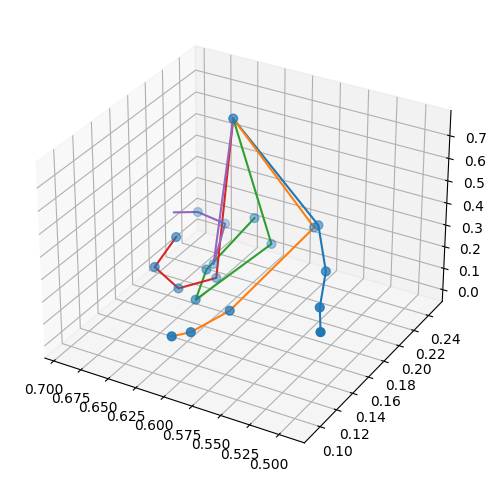

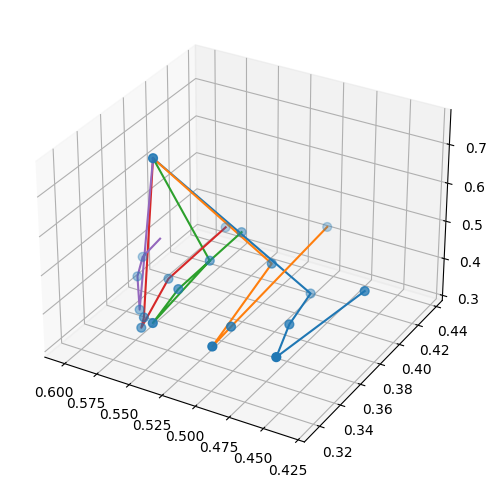

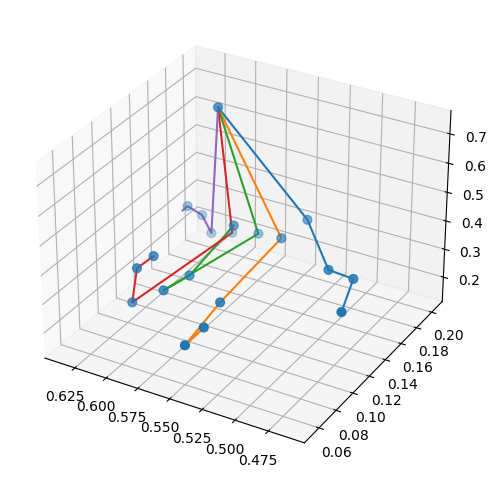

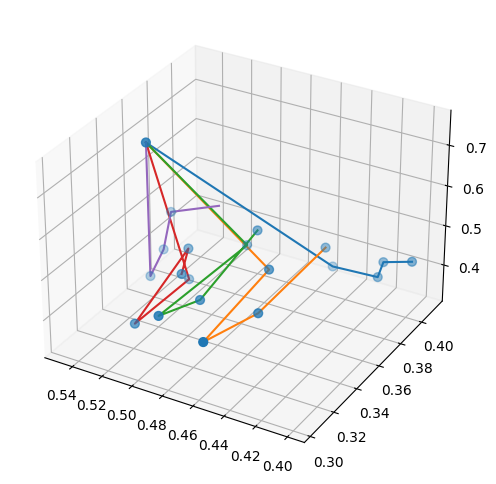

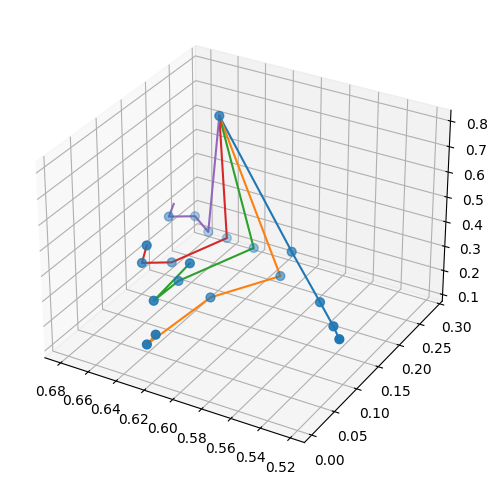

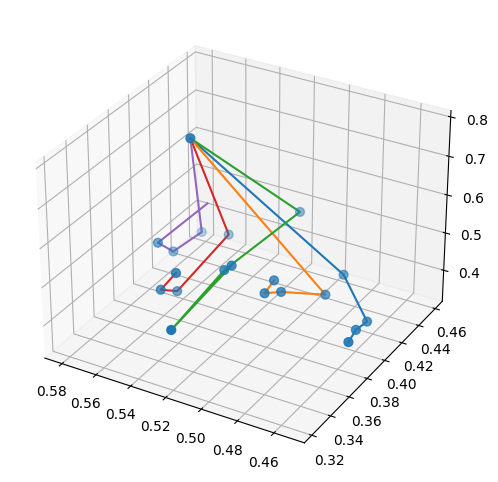

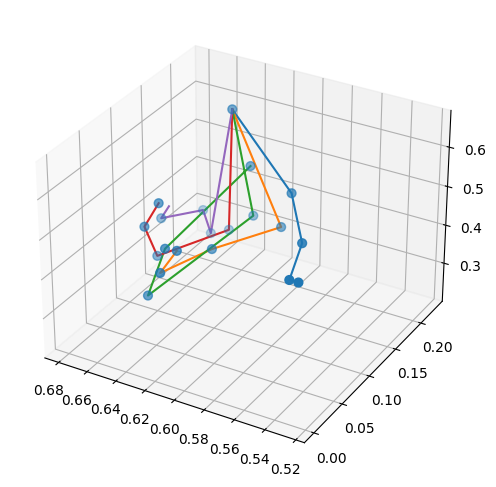

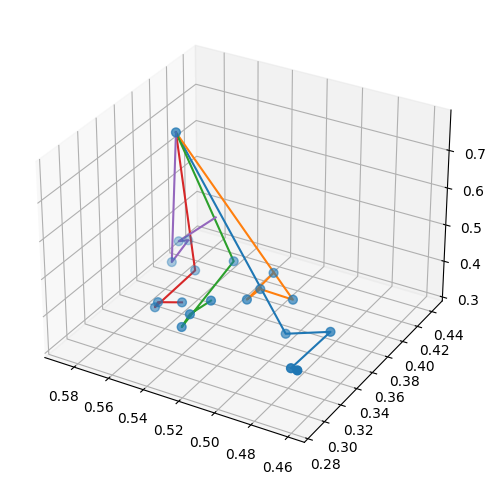

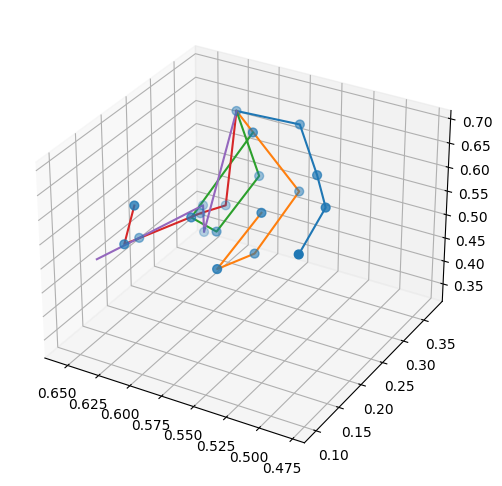

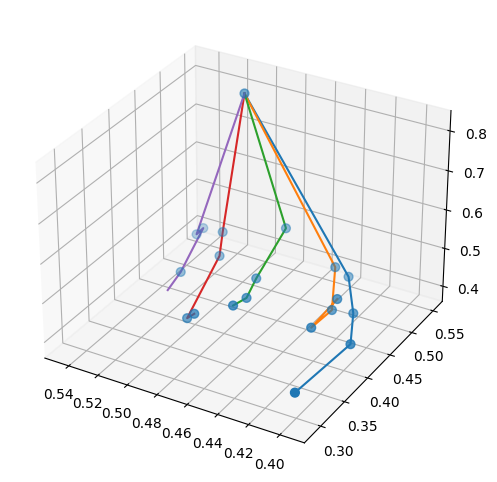

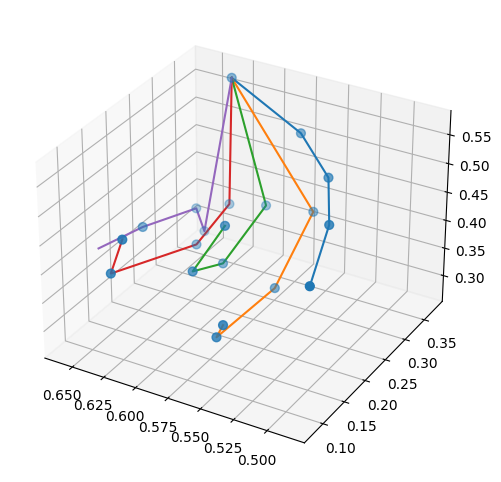

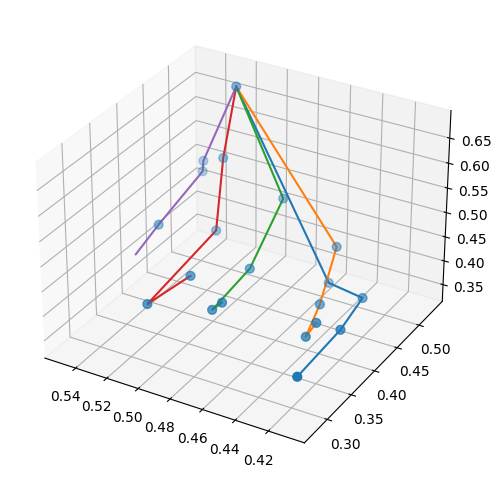

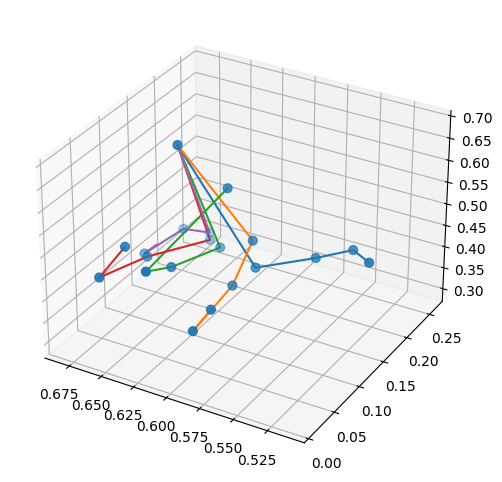

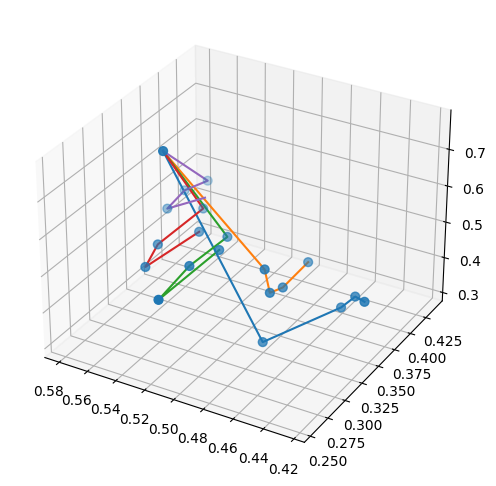

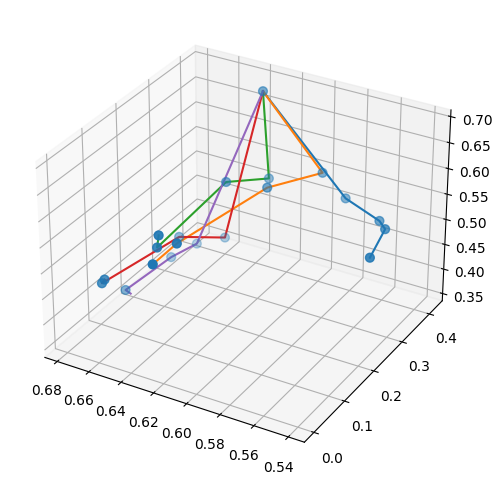

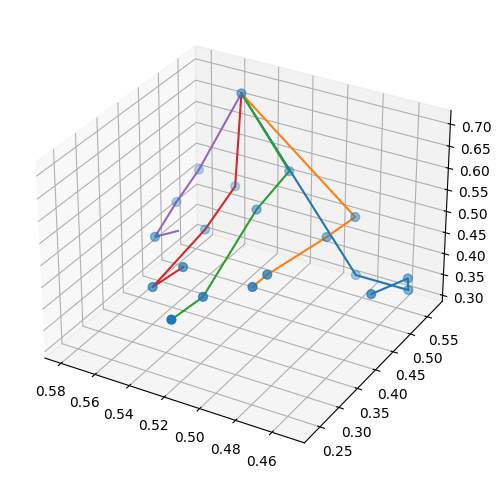

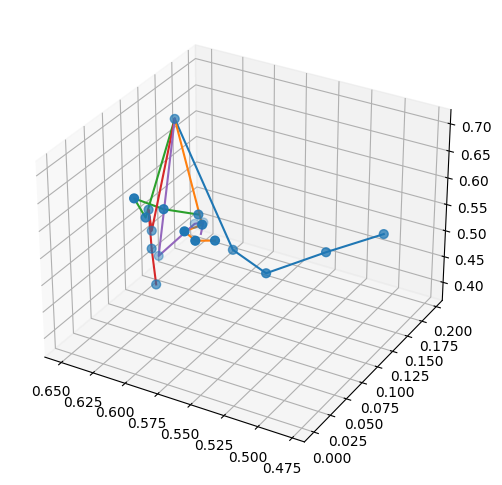

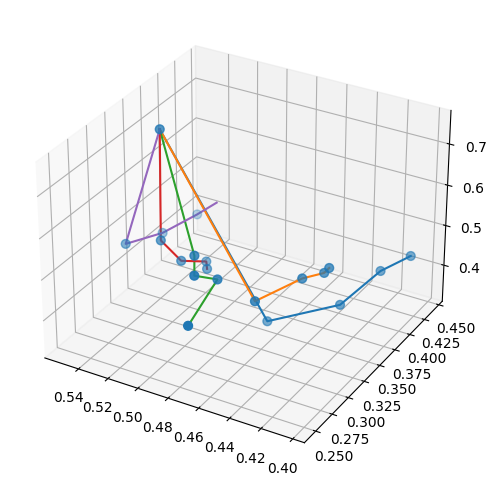

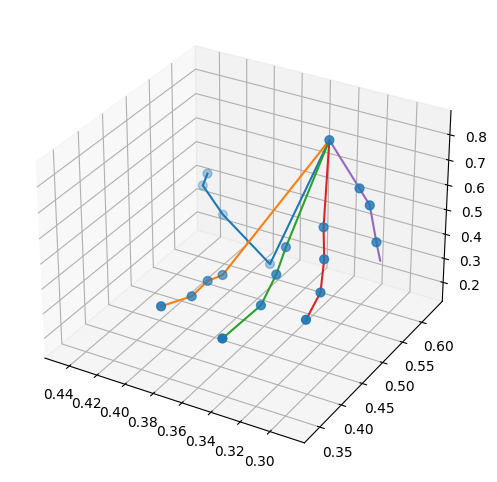

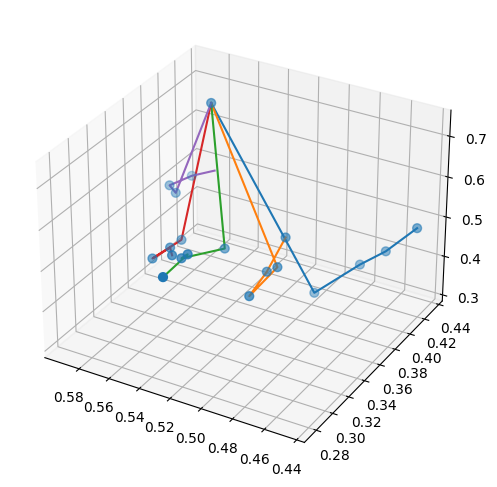

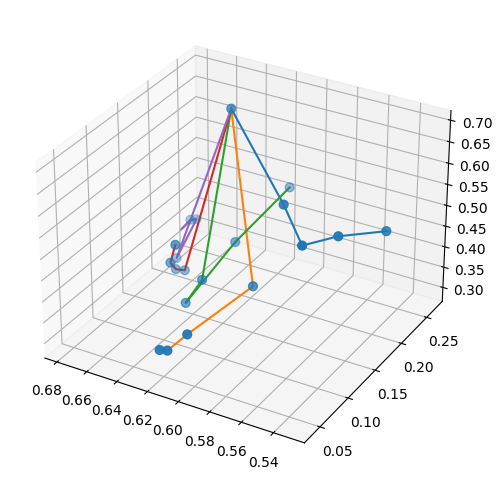

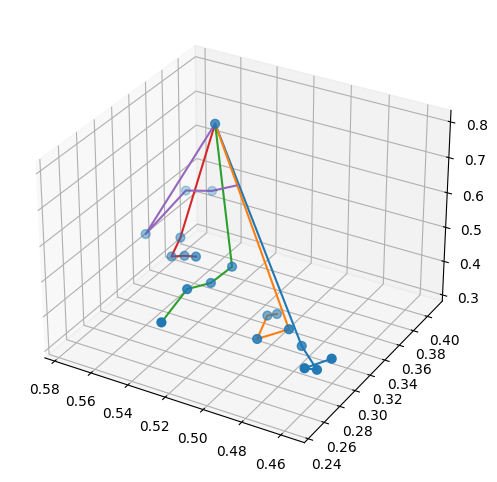

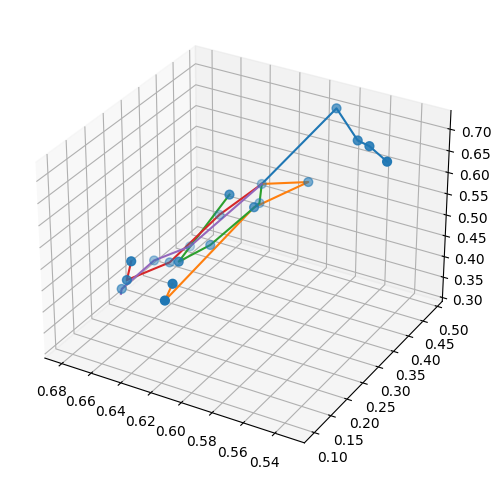

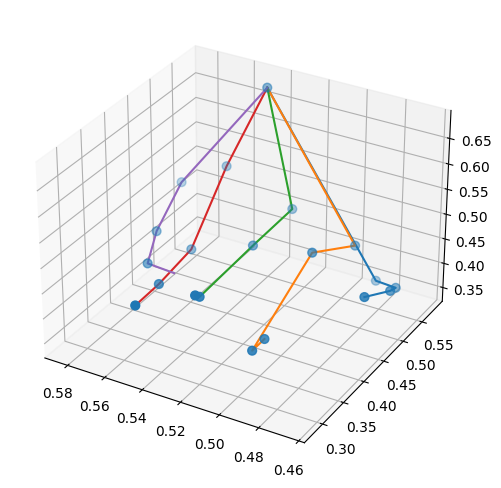

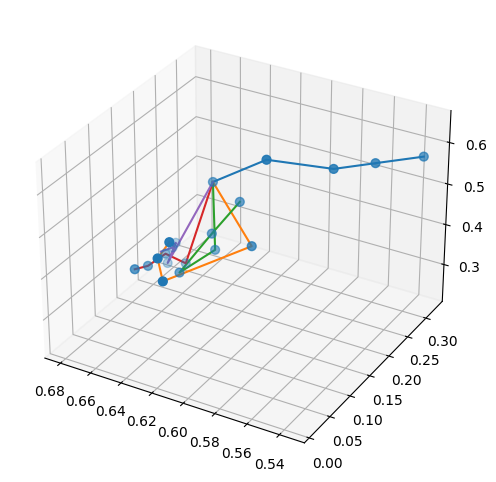

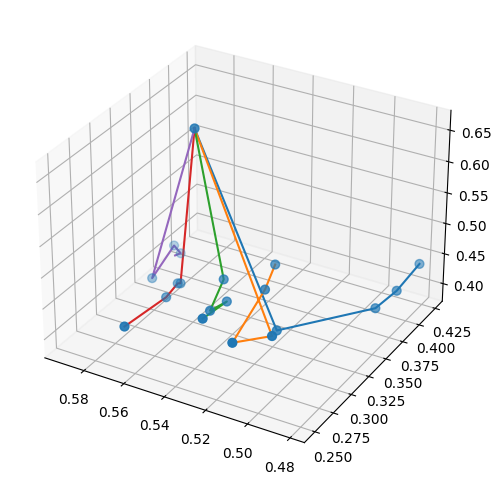

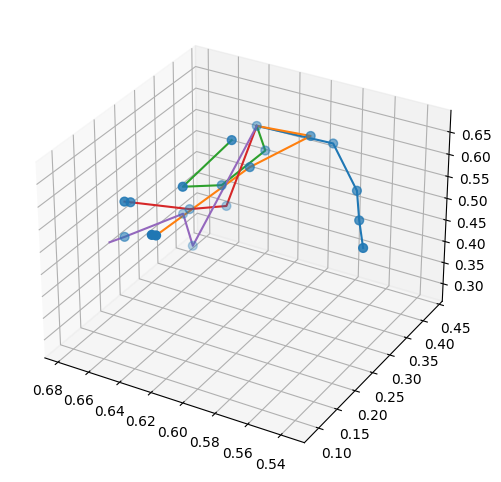

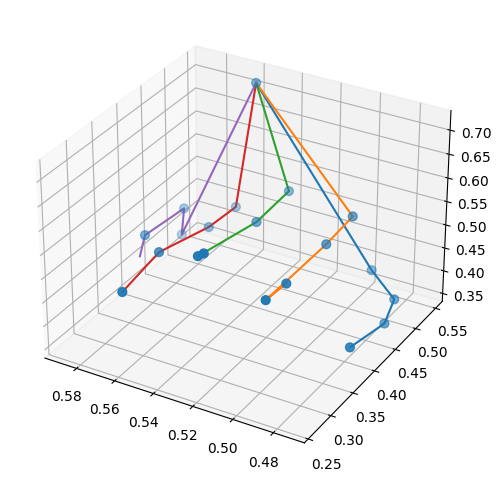

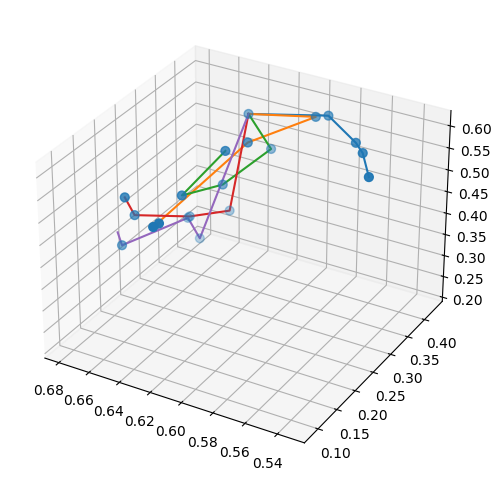

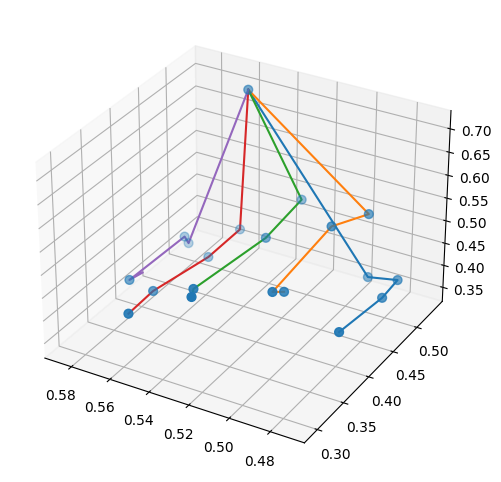

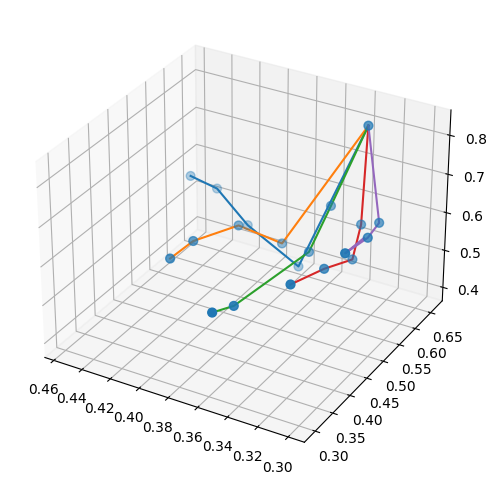

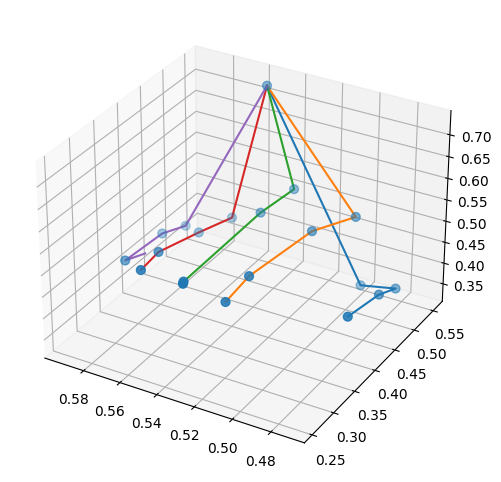

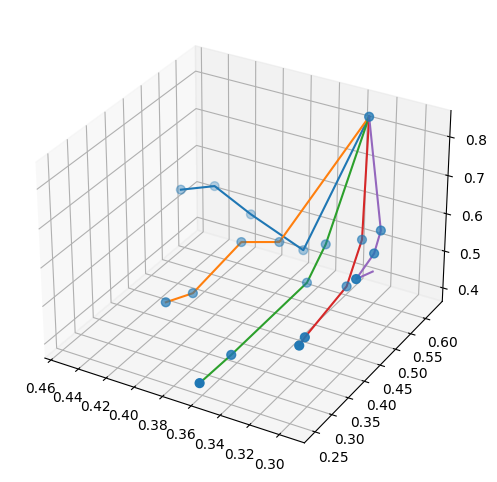

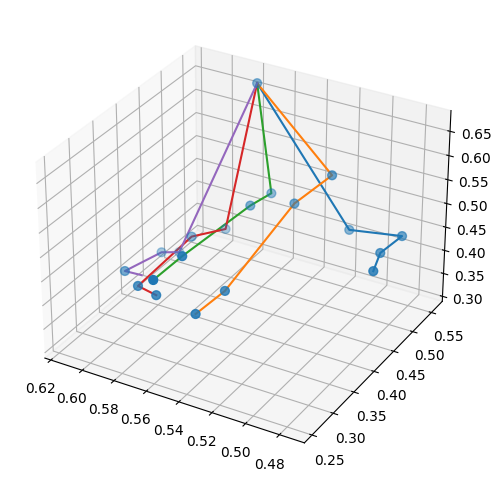

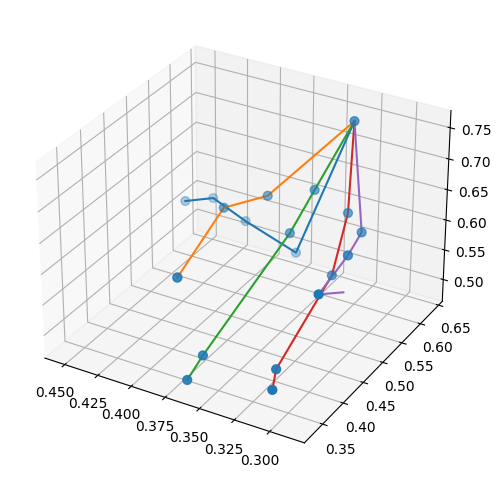

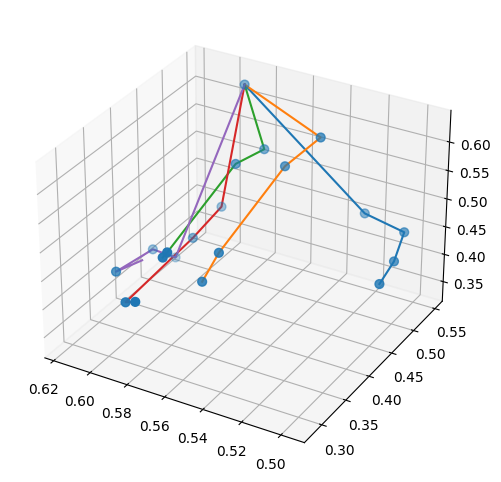

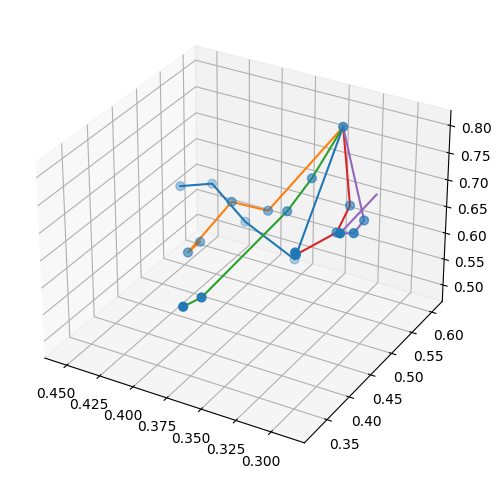

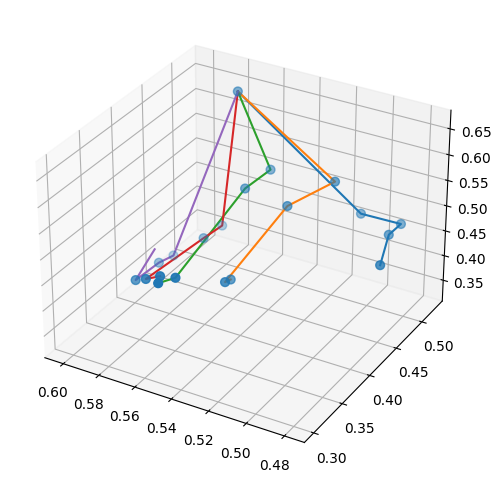

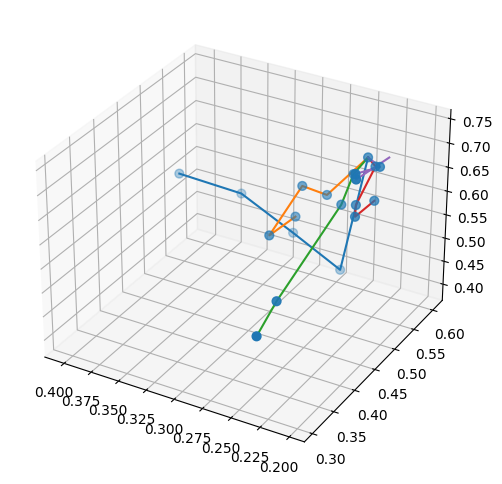

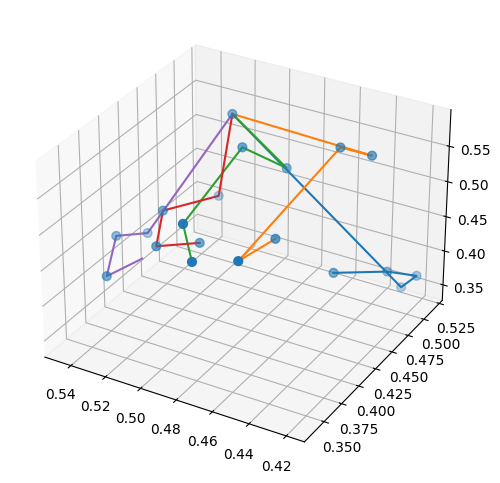

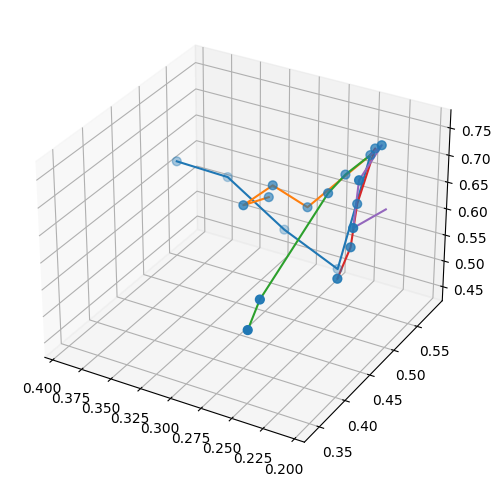

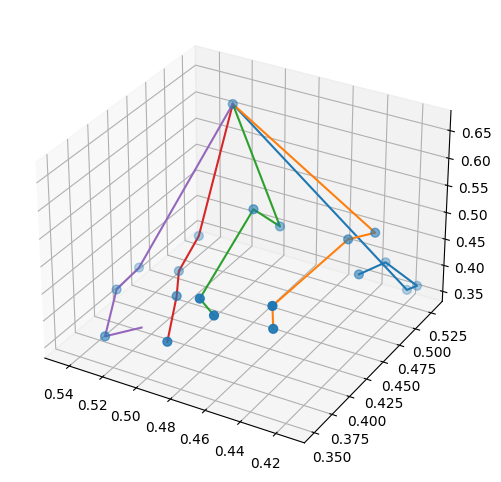

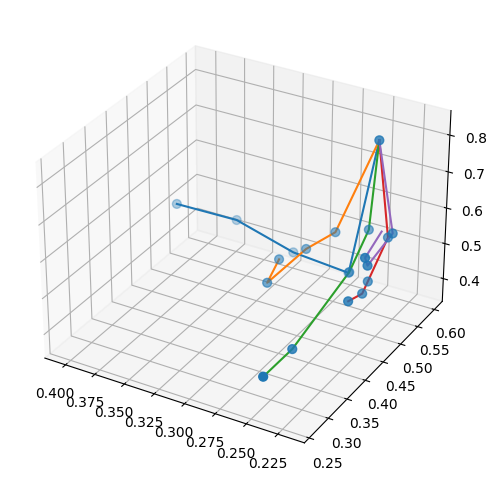

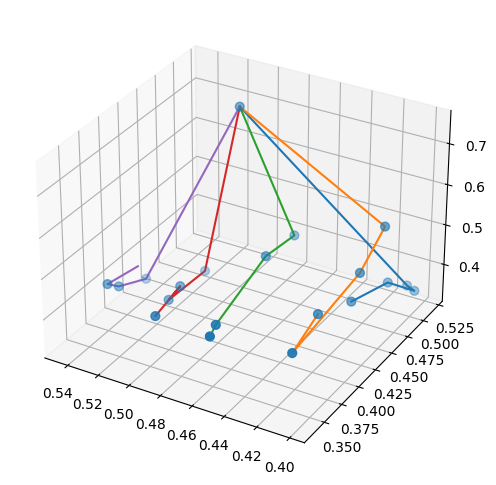

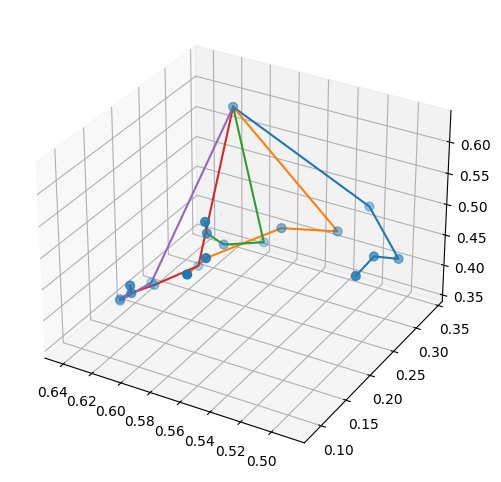

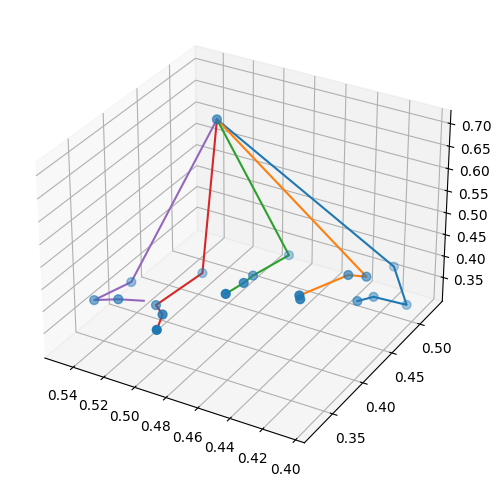

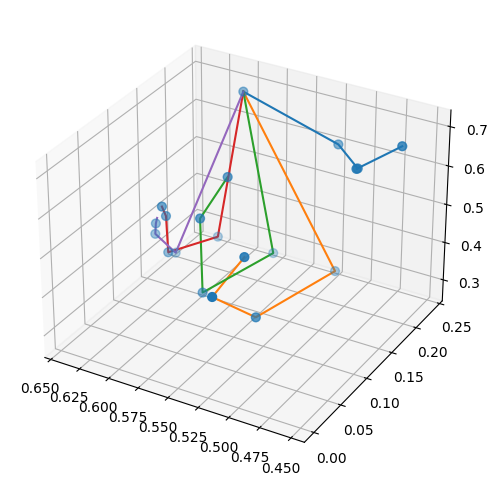

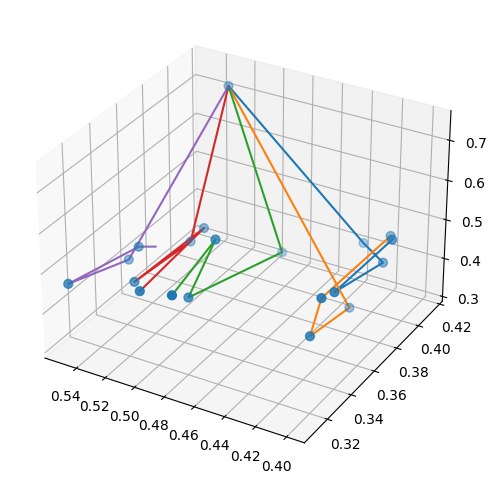

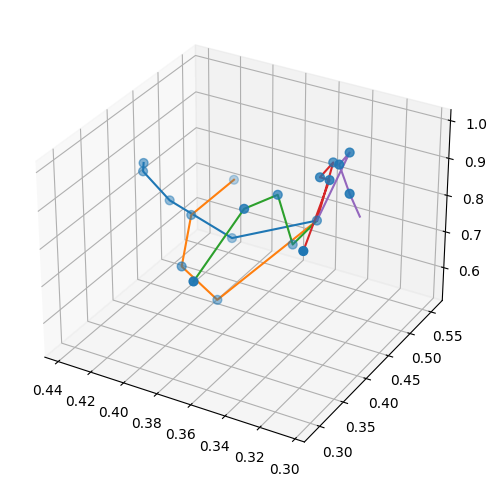

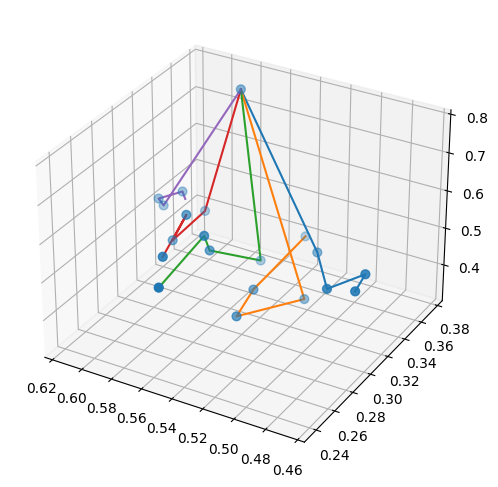

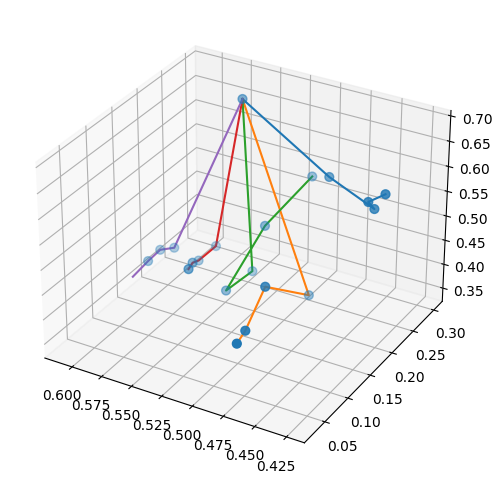

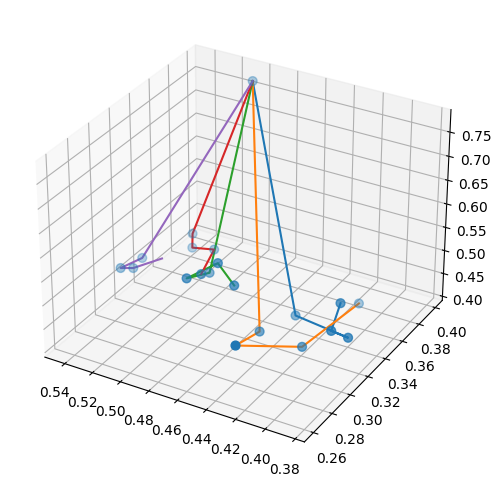

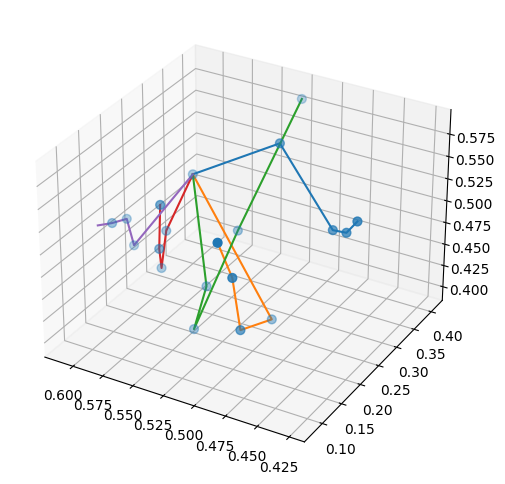

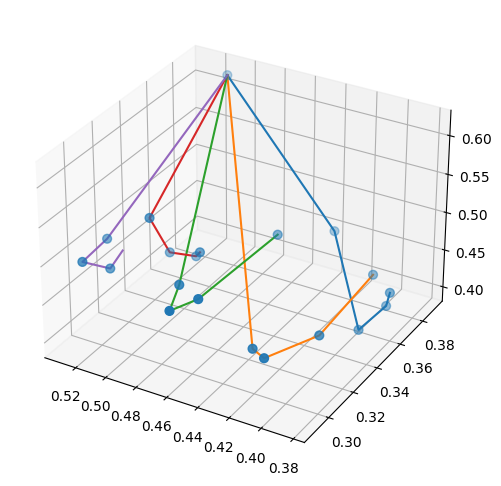

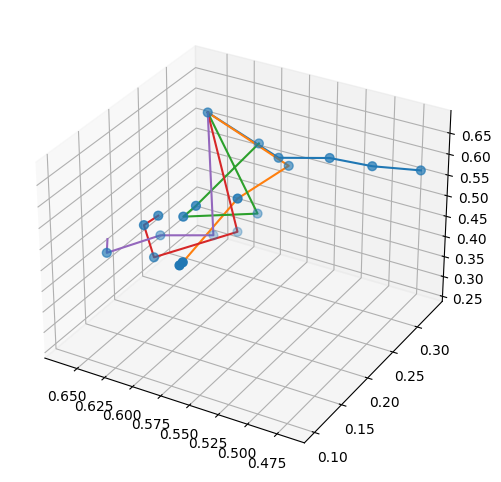

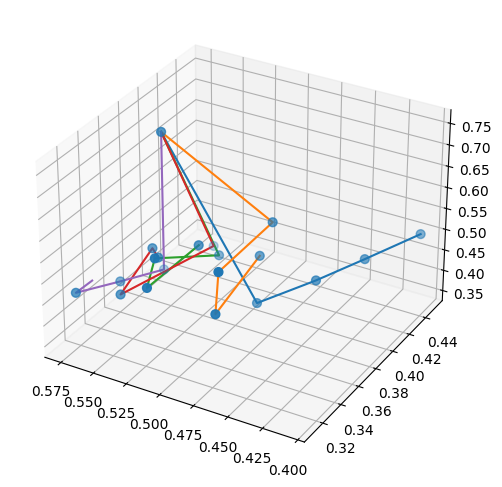

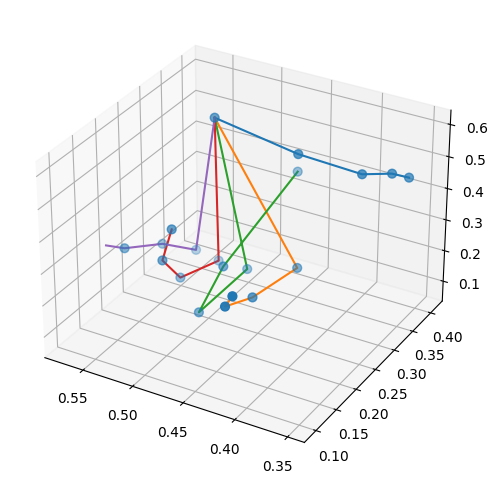

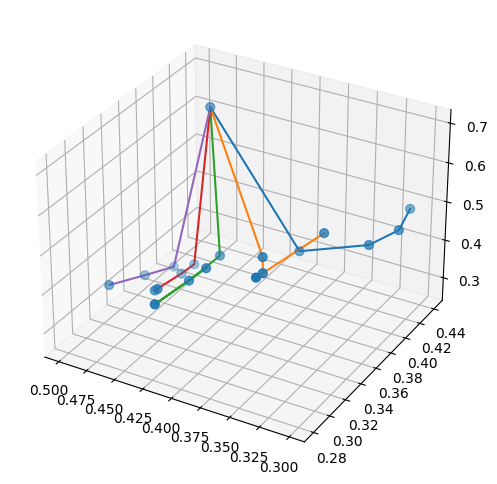

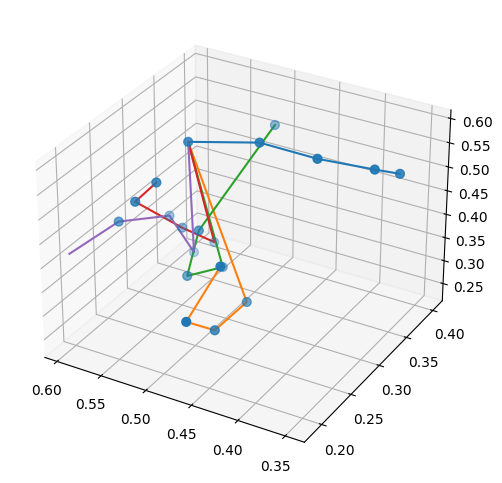

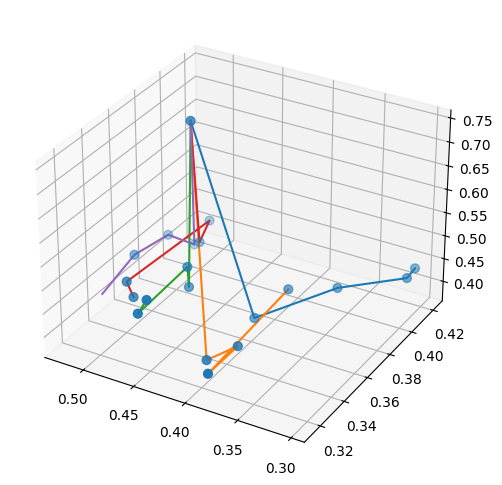

In [33]:
for frame_index in range(frame_count):
    
    # coord_division(skeleton_list) -- skeleton_list( 30, 126 )
    y_test_points_list          = coord_division(y_test_coord_list[frame_index])
    lstm_prediction_points_list = coord_division(lstm_prediction_coord_list[frame_index])
    
    # point restore
    y_test_hand_list.append(y_test_points_list)
    lstm_prediction_hand_list.append(lstm_prediction_points_list)
    
    # hand_visualization
    hand_visualization(y_test_points_list)
    hand_visualization(lstm_prediction_points_list)
    

## 7. PCA coefficient

* https://www.kaggle.com/code/bobaaayoung/pca-lstm

In [34]:
from sklearn.decomposition import PCA
from sklearn import preprocessing

def plt_visualize_PCA(evr):
    
    plt.figure(figsize=(8, 5))
    plt.plot(np.arange(1, len(evr) + 1), np.cumsum(evr*100), "-o")
    plt.title("PCA", fontsize=15)
    plt.xlabel("n_components",fontsize=15)
    plt.ylabel("(%)",fontsize=15)
    plt.xticks(range(1,len(evr),2),fontsize=12)
    plt.yticks(fontsize=12)
    plt.show()

def Data_PCA(input_data):
    scaler = preprocessing.StandardScaler().fit(input_data)
    
    X_scaled = scaler.transform(input_data)
    X_scaled = pd.DataFrame(X_scaled)
    
    estimator_pca = PCA(n_components=None)
    estimator_pca.fit(X_scaled)
    evr = estimator_pca.explained_variance_ratio_
    
    plt_visualize_PCA(evr) ## plt_visualize
    
def Apply_Data_PCA(input_data, n_component):
    scaler = preprocessing.StandardScaler().fit(input_data)
    
    X_scaled = scaler.transform(input_data)
    X_scaled = pd.DataFrame(X_scaled)
    
    pca = PCA(n_components=n_component)
    input_data_pca = pca.fit_transform(X_scaled)
    input_data_pca = pd.DataFrame(input_data_pca)
    
    print('PCA dimension Reduction：',X_scaled.shape,'-->',input_data_pca.shape)
    return input_data_pca


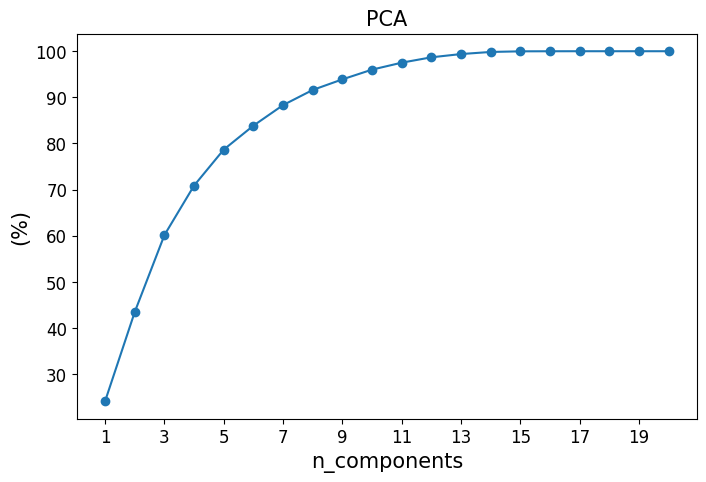

In [35]:
Data_PCA(extracted_features)

In [36]:
input_data_pca = Apply_Data_PCA(extracted_features,5)

PCA dimension Reduction： (150, 20) --> (150, 5)


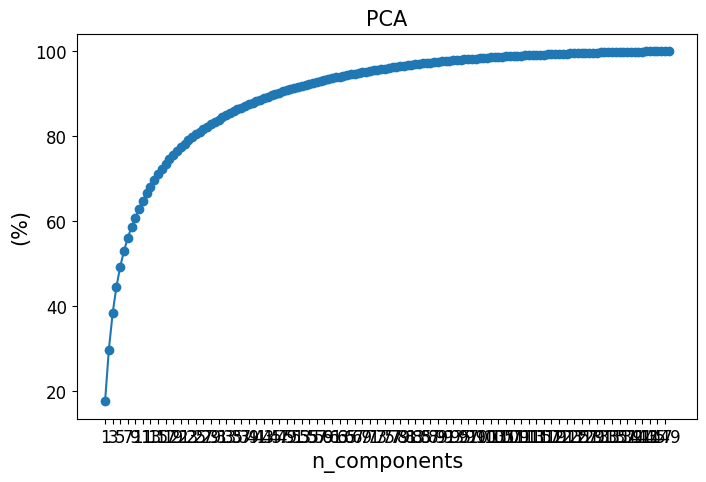

In [37]:
Data_PCA(extracted_contraction_skeleton)

In [38]:
output_data_pca = Apply_Data_PCA(extracted_contraction_skeleton,11)

PCA dimension Reduction： (150, 3780) --> (150, 11)


In [39]:
X_train, y_train, X_test, y_test = train_test_normalize(input_data_pca, output_data_pca)
print("X_train : ",X_train.shape, " y_train : ", y_train.shape)

print("X_test : ", X_test.shape, " y_test : ", y_test.shape)

(120, 5)
(120, 11)
(30, 5)
(30, 11)
X_train :  (120, 5, 1)  y_train :  (120, 11)
X_test :  (30, 5, 1)  y_test :  (30, 11)


In [40]:
from sklearn.metrics import mean_absolute_percentage_error
from sklearn.metrics import mean_squared_error